# Synthetic Experiments

This notebook runs enrollment simulations on fully synthetic data.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

# Utility Functions

A variety of simple functions used for generating groups, preferences, qualities, and estimates

In [2]:
def generate_normal_q_and_e(num_students, num_e, qm=0, qv=1, em=0, ev=1):
    '''
    generate num_students normal distributes with mean qm and variance qv
    generate num_e normal distributes with mean em and variance ev and add to q
    note that outputted es are of the form v + X (q + noise)
    '''
    qs = np.random.normal(qm, qv, num_students)
    noise_vals = np.random.normal(em, ev, num_e*num_students).reshape(num_students, num_e)
    es = qs.reshape(num_students, 1) + noise_vals
    return qs, es

def generate_uniform_preferences(num_students, num_schools):
    '''
    Generate num_students permutations of 0, ..., num_schools - 1
    these act as the preferences of the students
    '''
    return [np.random.permutation(num_schools).tolist() for _ in range(num_students)]

def get_rankings_from_estimates_2(es, strategies):
    school_rankings = []
    for strategy in strategies:
        # sort in descending order
        school_rankings.append(np.argsort(es[:, strategy])[::-1])
    return np.array(school_rankings)

def get_rankings_from_estimates(estimates, school_strategies):
    '''
    Given estimates and school strategies, return rankings (highest quality to lowest quality) for each school
    school strategies is a list of length m, where m[i] is the index of es corresponding to the estimate school i uses. 
    In standard polyculture setting, this should be range(m).
    '''
    school_rankings = []
    for i in range(len(school_strategies)):
        # sort in descending order
        school_rankings.append(np.argsort(estimates[:, school_strategies[i]])[::-1])
    return np.array(school_rankings)

def generate_exact_groups(num_students, g0):
    '''
    generate a list of length num_students where a random subset of size g1 are 0 and 1 otherwise
    '''
    groups = [1 for _ in range(num_students)]
    for i in range(g0):
        groups[i] = 0
    np.random.shuffle(groups)
    return groups

def get_per_group_rankings(estimates, groups, school_strategies):
    '''
    Given estimates, groups, and school strategies, return per-group rankings (highest quality to lowest quality) for each school
    - assumes groups is a vector of either 0 or 1
    - school strategies is a list of length m, where m[i] is the index of es corresponding to the estimate school i uses. 
    In standard polyculture setting, this should be range(m).
    '''
    assert(max(school_strategies) < len(estimates))
    school_rankings = []

    group_0_indices = np.where(np.array(groups) == 0)[0]
    group_1_indices = np.where(np.array(groups) == 1)[0]
    for i in range(len(school_strategies)):
        group_0_estimates = estimates[group_0_indices, school_strategies[i]]
        group_1_estimates = estimates[group_1_indices, school_strategies[i]]
        group_0_ranking = group_0_indices[np.argsort(group_0_estimates)[::-1]]
        group_1_ranking = group_1_indices[np.argsort(group_1_estimates)[::-1]]

        school_rankings.append((group_0_ranking, group_1_ranking))

    return school_rankings

def get_interleaved_group_rankings(group_0_ranking, group_1_ranking):
    interleaved = []
    num = max(len(group_0_ranking), len(group_1_ranking))
    for i in range(num):
        if i < len(group_0_ranking):
            interleaved.append(group_0_ranking[i])
        if i < len(group_1_ranking):
            interleaved.append(group_1_ranking[i])
    return interleaved

def next_nonlegacy(curr_rank, school, ranking, legacy_info):
    next_rank = curr_rank
    while next_rank == curr_rank or legacy_info[ranking[next_rank]] == school:
        next_rank += 1
    return next_rank

def next_legacy(curr_rank, school, ranking, legacy_info):
    next_rank = curr_rank
    while next_rank == curr_rank or legacy_info[ranking[next_rank]] != school:
        next_rank += 1
    return next_rank

def update_enrolment(admit, school, enrolled_school, preferences, legacy_info, num_legacy, num_nonlegacy):
    if enrolled_school[admit] == -1:
        enrolled_school[admit] = school
        if legacy_info[admit] == school:
            num_legacy[school] += 1
        else:
            num_nonlegacy[school] += 1

    if preferences[admit].index(school) < preferences[admit].index(enrolled_school[admit]): 
        if legacy_info[admit] == enrolled_school[admit]:
            num_legacy[enrolled_school[admit]] -= 1
        else:
            num_nonlegacy[enrolled_school[admit]] -= 1
        
        enrolled_school[admit] = school
        if legacy_info[admit] == school:
            num_legacy[school] += 1
        else:
            num_nonlegacy[school] += 1

def deferred_acceptance(school_rankings, preferences, legacy_info, cap_legacy, cap_nonlegacy):
    enrolled_school = [-1] * len(preferences)

    num_legacy = [0] * len(school_rankings)
    num_nonlegacy = [0] * len(school_rankings)
    rank_last_legacy = [-1] * len(school_rankings)
    rank_last_nonlegacy = [-1] * len(school_rankings)

    while num_legacy != cap_legacy or num_nonlegacy != cap_nonlegacy:
        for school, ranking in enumerate(school_rankings):
            if num_legacy[school] < cap_legacy[school]:
                # admit another legacy student
                rank_last_legacy[school] = next_legacy(rank_last_legacy[school], school, ranking, legacy_info)
                admit = ranking[rank_last_legacy[school]]
                update_enrolment(admit, school, enrolled_school,preferences, legacy_info, num_legacy, num_nonlegacy)
                
            if num_nonlegacy[school] < cap_nonlegacy[school]:
                # admit another nonlegacy student
                rank_last_nonlegacy[school] = next_nonlegacy(rank_last_nonlegacy[school], school, ranking, legacy_info)
                admit = ranking[rank_last_nonlegacy[school]]
                update_enrolment(admit, school, enrolled_school,preferences, legacy_info, num_legacy, num_nonlegacy)
    
    last_legacy = [school_rankings[s][r] if r != -1 else None for (s,r) in enumerate(rank_last_legacy)]
    last_nonlegacy = [school_rankings[s][r] if r != -1 else None for (s,r) in enumerate(rank_last_nonlegacy)]
    return enrolled_school, last_legacy, last_nonlegacy


## Example Run

In [3]:
num_students = 30000
capacity = 10000
num_schools = 8
setting = 'mono'

qualities, estimates = generate_normal_q_and_e(num_students, num_schools)
preferences = generate_uniform_preferences(num_students, num_schools)

legacy_info = [-1] * num_students

strategy = list(range(num_schools)) if setting == 'poly' else [0] * num_schools


rankings = get_rankings_from_estimates(estimates, strategy)

enrolled, _, _ = deferred_acceptance(
    rankings, preferences, legacy_info,
    cap_legacy=[0] * num_schools,
    cap_nonlegacy=[capacity / num_schools] * num_schools
)

print( sum([enrolled[stu] == preferences[stu][0] for stu in range(num_students)]) )

9869


# Demographic Considerations

For associated discussion, see *Admissions with Demographic Considerations* in Section 5.1 of the Arxiv manuscript.

### Proportion in Enrolled Class

Our first claim we simulate and explore is that in a polyculture, where students are admitted at equal rates, 

$$\lim_{m \rightarrow \infty}\frac{\Pr[\mu(\theta) = c, a_{\theta} = g]}{\Pr[\mu(\theta) = c]} = \alpha_g$$


In [4]:
def group_proportion_experiment(num_schools, setting='mono', num_students=40000, capacity=4000, g0=0.25, qm=0, qv=1, em=0, ev=1, T=2):
    capacities = [capacity / num_schools] * num_schools
    g0_proportion = np.zeros(T)

    for t in range(T):
        qualities, estimates = generate_normal_q_and_e(num_students, num_schools, qm, qv, em, ev)
        preferences = generate_uniform_preferences(num_students, num_schools)
        groups = generate_exact_groups(num_students, round(num_students * g0))
        legacy_info = [-1] * num_students

        strategy = list(range(num_schools)) if setting == 'poly' else [0] * num_schools

        group_rankings = get_per_group_rankings(estimates, groups, strategy)
        rankings = [get_interleaved_group_rankings(r[0], r[1]) for r in group_rankings]

        enrolled, _, _ = deferred_acceptance(
            rankings, preferences, legacy_info,
            cap_legacy=[0] * num_schools,
            cap_nonlegacy=capacities
        )

        g0_admits = sum(1 for s in range(num_students) if enrolled[s] != -1 and groups[s] == 0)
        g0_proportion[t] = g0_admits / capacity

    return g0_proportion

## Generating Data

This cell generates data, and the second cell plots the data. This cell can be skipped and the next cell will plot pre-generated data.

In [5]:
num_schools = [2, 4, 5, 8, 10, 16, 20, 25, 32, 40] 
T = 4000
settings = ['poly', 'mono']

data = {}
for setting in settings:
    prop_mean = []
    prop_std_err = []

    for n in num_schools:
        prop = group_proportion_experiment(num_schools=n, setting=setting, T=T)
        prop_mean.append(np.mean(prop))
        prop_std_err.append(np.std(prop) / np.sqrt(T))

    data[setting] = {
        'num_schools': num_schools,
        'prop_mean': prop_mean,
        'prop_std_err': prop_std_err
    }

np.save('plots/group_proportion_data-4000.npy', data)

## Plot

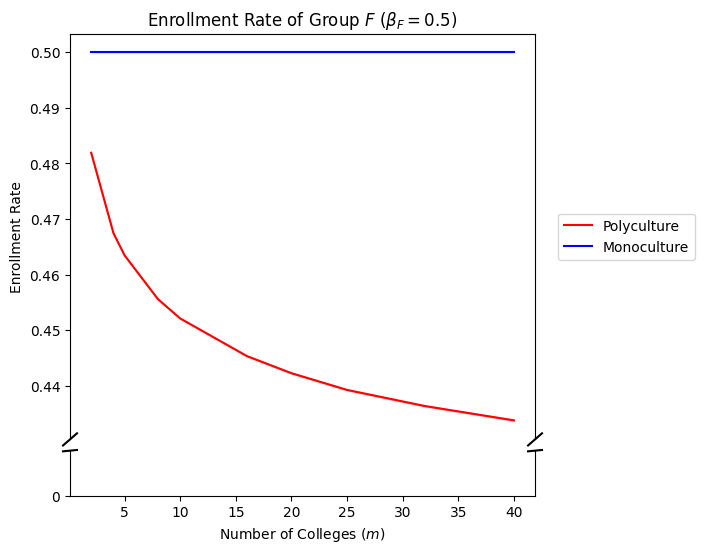

In [21]:
data = np.load('plots/group_proportion_data-4000.npy', allow_pickle=True).item()
labels = ['Polyculture', 'Monoculture']
colors = ['red', 'blue']

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 6), gridspec_kw={'height_ratios': [9, 1]})
fig.subplots_adjust(hspace=0.05)

settings = ['poly', 'mono']
for i, setting in enumerate(settings):
    num_schools = data[setting]['num_schools']
    prop_mean = data[setting]['prop_mean']
    prop_std_err = data[setting]['prop_std_err']

    ax1.plot(num_schools, prop_mean, label=labels[i], color=colors[i], linestyle='-')
    ax1.fill_between(
        num_schools,
        np.array(prop_mean) - np.array(prop_std_err),
        np.array(prop_mean) + np.array(prop_std_err),
        alpha=0.2,
        color=colors[i]
    )

ax1.legend()
ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)
ax1.set_ylabel(r'Enrollment Rate')
ax2.set_xlabel(r'Number of Colleges $(m)$')
ax1.set_title(r'Enrollment Rate of Group $F$ $(\beta_F = 0.5)$')

ax2.set_ylim(0, 0.01)      

yticks_upper = np.arange(0.40, 0.51, 0.01)
yticks_lower = np.arange(0, 0.01, 0.01)

ax1.set_yticks(yticks_upper)
ax2.set_yticks(yticks_lower)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.xaxis.tick_bottom()

# Add diagonal lines to indicate the break
d = .015  
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)

# Diagonals for upper plot
ax1.plot((-d, +d), (-d, +d), **kwargs)        # Top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

# Diagonals for lower plot
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)   # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig('plots/groups_proportion-tresman.pdf',
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=300)
plt.show()

# Legacy Experiments

For associated discussion, see *Admissions with Preference Information* in Section 5.1 of the Arxiv manuscript.

## Helper function used to run experiment

In [7]:
def legacy_experiment(prop, legacy_rate, num_schools= 10, setting='mono', num_students=40000, capacity=4000, qm=0, qv=1, em=0, ev=1, T=2):
    quality_legacy = np.zeros(T)
    quality_nonlegacy = np.zeros(T)
    quality_enrolled = np.zeros(T)
    
    cap_nonlegacy = [round(((1 - prop) * capacity) / num_schools)] * num_schools
    cap_legacy = [round((prop * capacity) / num_schools)] * num_schools
    assert (sum(cap_legacy) + sum(cap_nonlegacy) == capacity)

    for t in range(T):
        qualities, estimates = generate_normal_q_and_e(num_students, num_schools, qm, qv, em, ev)
        preferences = generate_uniform_preferences(num_students, num_schools)

        legacy_info = { student:-1 for student in range(num_students)}
        for school in range(num_schools):
            students_with_rank_1 = [ student for student,pref in enumerate(preferences) if pref[0] == school ]
            l = len(students_with_rank_1)
            groups = generate_exact_groups(l, round(l * legacy_rate))
            legacy_info |= {student:school for i,student in enumerate(students_with_rank_1) if groups[i]==0 }

        strategy = [0] * num_schools
        if setting == 'poly':
            strategy = list(range(num_schools))
        
        rankings = get_rankings_from_estimates(estimates, strategy)

        enrolled, last_legacy, last_nonlegacy = deferred_acceptance(rankings, preferences, legacy_info, cap_legacy=cap_legacy, cap_nonlegacy=cap_nonlegacy)
        quality_legacy[t] = np.average([qualities[student] for student in last_legacy ])
        quality_nonlegacy[t] = np.average([qualities[student]  for student in last_nonlegacy ])
        quality_enrolled[t] = np.average([qualities[student]  for student, school in enumerate(enrolled) if school != -1] )

    return quality_legacy, quality_nonlegacy, quality_enrolled

## Generating Data

This cell generates data, and the second cell plots the data. This cell can be skipped and the next cell will plot pre-generated data (Note that data generation may take significant time). 

In [8]:
proportions = {
    'poly' : [1/20 * i for i in range(1, 10)],
    'mono' : [1/20 * i for i in range(1, 20)]
}

T = 5000
legacy_rate = 0.5 
num_schools = 10 

data = {}
for setting in proportions.keys():
    q_legacy_mean = []
    q_legacy_std_err = []
    q_nonlegacy_mean = []
    q_nonlegacy_std_err = []
    q_enrolled_mean = []
    q_enrolled_std_err = []

    for prop in proportions[setting]:
        quality_legacy, quality_nonlegacy, quality_enrolled = legacy_experiment(prop=prop, num_schools=num_schools, legacy_rate=legacy_rate, setting=setting, T=T)
        q_legacy_mean.append(np.mean(quality_legacy))
        q_legacy_std_err.append(np.std(quality_legacy) / np.sqrt(T))
        q_nonlegacy_mean.append(np.mean(quality_nonlegacy))
        q_nonlegacy_std_err.append(np.std(quality_nonlegacy) / np.sqrt(T))
        q_enrolled_mean.append(np.mean(quality_enrolled))
        q_enrolled_std_err.append(np.std(quality_enrolled) / np.sqrt(T))
    
    data[setting] = {
        'proportions' : proportions[setting],
        'q_legacy_mean': q_legacy_mean,
        'q_legacy_std_err' : q_legacy_std_err,
        'q_nonlegacy_mean' : q_nonlegacy_mean,
        'q_nonlegacy_std_err': q_nonlegacy_std_err, 
        'q_enrolled_mean': q_enrolled_mean, 
        'q_enrolled_std_err':q_enrolled_std_err
    }

np.save('plots/legacy_quality_data-4000.npy', data)

## Plot

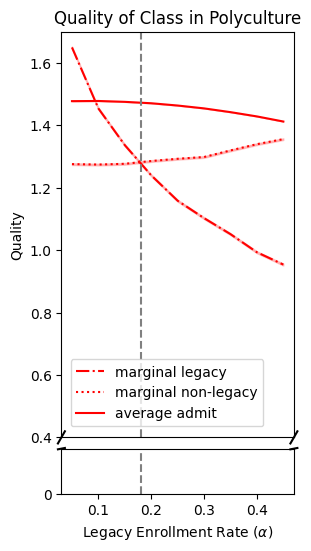

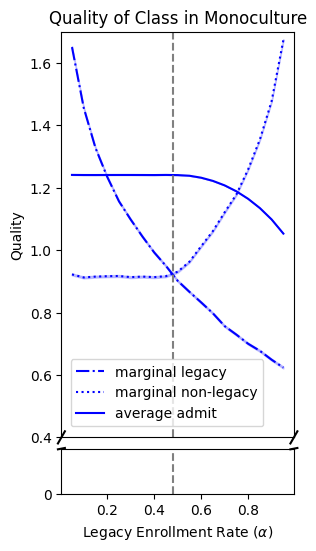

In [23]:
data = np.load('plots/legacy_quality_data-4000.npy', allow_pickle=True).item()
settings = ['poly', 'mono']
labels = ['Polyculture', 'Monoculture']
colors = ['red', 'blue'] 

for i, setting in enumerate(settings):
    proportions = data[setting]['proportions']
    q_legacy_mean = data[setting]['q_legacy_mean']
    q_legacy_std_err = data[setting]['q_legacy_std_err']
    q_nonlegacy_mean = data[setting]['q_nonlegacy_mean']
    q_nonlegacy_std_err = data[setting]['q_nonlegacy_std_err']
    q_enrolled_mean = data[setting]['q_enrolled_mean']
    q_enrolled_std_err = data[setting]['q_enrolled_std_err']

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(3, 6), gridspec_kw={'height_ratios': [9, 1]})
    fig.subplots_adjust(hspace=0.05)

    handle = ax1
    handle.plot(proportions, q_legacy_mean, label="marginal legacy", color=colors[i], linestyle='-.')
    handle.fill_between(proportions, 
                    np.array(q_legacy_mean) - np.array(q_legacy_std_err), 
                    np.array(q_legacy_mean) + np.array(q_legacy_std_err),
                    alpha=0.2, color=colors[i])
    
    handle.plot(proportions, q_nonlegacy_mean, label="marginal non-legacy", color=colors[i], linestyle=':')
    handle.fill_between(proportions, 
                    np.array(q_nonlegacy_mean) - np.array(q_nonlegacy_std_err), 
                    np.array(q_nonlegacy_mean) + np.array(q_nonlegacy_std_err),
                    alpha=0.2, color=colors[i])
    
    handle.plot(proportions, q_enrolled_mean, label="average admit", color=colors[i], linestyle='-')
    handle.fill_between(proportions, 
                    np.array(q_enrolled_mean) - np.array(q_enrolled_std_err), 
                    np.array(q_enrolled_mean) + np.array(q_enrolled_std_err),
                    alpha=0.2, color=colors[i])


    if setting == 'poly':
        ax1.axvline(x=0.18 , color='gray', linestyle='--')
        ax2.axvline(x=0.18 , color='gray', linestyle='--')
    else:
        ax1.axvline(x=0.48 , color='gray', linestyle='--')
        ax2.axvline(x=0.48 , color='gray', linestyle='--')


    ax1.set_ylim(0.4, 1.7)   
    ax2.set_ylim(0, 0.01)      

    yticks_upper = np.arange(0.4, 1.61, 0.2)
    yticks_lower = np.arange(0, 0.01, 0.01)
    xticks_lower = np.arange(0, 1.1, 0.1 * (i + 1) )

    ax1.set_yticks(yticks_upper)
    ax2.set_yticks(yticks_lower)
    ax2.set_xticks(xticks_lower)

    # Hide spines between plots
    ax1.spines['bottom'].set_visible(True)
    ax2.spines['top'].set_visible(True)

    # Tick Marks
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax2.xaxis.tick_bottom()

    # Add diagonal lines to indicate the break
    d = .015  # Size of diagonal lines
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)

    # Diagonals for upper plot
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # Top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

    # Diagonals for lower plot
    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)   # Bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

    handle.legend(loc='lower left', bbox_to_anchor=(0.01, 0.01))
    ax2.set_xlabel(r'Legacy Enrollment Rate $(\alpha)$')
    handle.set_ylabel(r'Quality')
    handle.set_title(f'Quality of Class in {labels[i]}')

    if not os.path.exists("plots"):
        os.makedirs("plots")
    plt.savefig(f'plots/legacy_experiments-{settings[i]}-4000.pdf',
                bbox_inches='tight',
                pad_inches=0.1,
                dpi=300)
    
    plt.show()

Next we compare the average quality of students in a (blind) polyculture vs an aware polyculture.

## Helper function for experiment

In [24]:
def run_legacy_experiment(num_schools=4, T = 200):
    legacy_rate=1
    proportions = [1/20 * i for i in range(1, 20)]
    settings  = ['blind', 'aware']
    data = {}
    for setting in settings:
        q_legacy_mean = []
        q_legacy_std_err = []
        q_nonlegacy_mean = []
        q_nonlegacy_std_err = []
        q_enrolled_mean = []
        q_enrolled_std_err = []

        for prop in proportions:
            if setting == 'aware':
                quality_legacy, quality_nonlegacy, quality_enrolled = legacy_experiment(prop=prop, num_schools=num_schools, legacy_rate=legacy_rate, setting='poly', T=T)
            else:
                # treat all students as non-legacy; hence legacy enrollment prop = 0 and legacy_rate = 0
                quality_legacy, quality_nonlegacy, quality_enrolled = legacy_experiment(prop=0, num_schools=num_schools, legacy_rate=0, setting='poly', T=T)
            
            q_legacy_mean.append(np.mean(quality_legacy))
            q_legacy_std_err.append(np.std(quality_legacy) / np.sqrt(T))
            q_nonlegacy_mean.append(np.mean(quality_nonlegacy))
            q_nonlegacy_std_err.append(np.std(quality_nonlegacy) / np.sqrt(T))
            q_enrolled_mean.append(np.mean(quality_enrolled))
            q_enrolled_std_err.append(np.std(quality_enrolled) / np.sqrt(T))
        
        data[setting] = {
            'proportions' : proportions,
            'q_legacy_mean': q_legacy_mean,
            'q_legacy_std_err' : q_legacy_std_err,
            'q_nonlegacy_mean' : q_nonlegacy_mean,
            'q_nonlegacy_std_err': q_nonlegacy_std_err, 
            'q_enrolled_mean': q_enrolled_mean, 
            'q_enrolled_std_err':q_enrolled_std_err
        }

    np.save(f'plots/blind-aware-poly-N{num_schools}-T{T}.npy', data)

def plot_legacy_experiment_result(num_schools=4, T=200, xline=None):
    data = np.load(f'plots/blind-aware-poly-N{num_schools}-T{T}.npy', allow_pickle=True).item()
    labels = ['Polyculture', 'Monoculture']
    colors = ['black', 'red'] 

    fig, axs = plt.subplots(2, 1) 

    settings  = ['blind', 'aware']
    for i, setting in enumerate(settings):
        proportions = data[setting]['proportions']
        q_legacy_mean = data[setting]['q_legacy_mean']
        q_legacy_std_err = data[setting]['q_legacy_std_err']
        q_nonlegacy_mean = data[setting]['q_nonlegacy_mean']
        q_nonlegacy_std_err = data[setting]['q_nonlegacy_std_err']
        q_enrolled_mean = data[setting]['q_enrolled_mean']
        q_enrolled_std_err = data[setting]['q_enrolled_std_err']

        handle = axs[0]
        
        if setting == 'aware':
            axs[1].plot(proportions, q_legacy_mean, label="marginal legacy", color=colors[i], linestyle='-.')
            axs[1].fill_between(proportions, 
                            np.array(q_legacy_mean) - np.array(q_legacy_std_err), 
                            np.array(q_legacy_mean) + np.array(q_legacy_std_err),
                            alpha=0.2, color=colors[i])
            
            axs[1].plot(proportions, q_nonlegacy_mean, label="marginal non-legacy", color=colors[i], linestyle=':')
            axs[1].fill_between(proportions, 
                            np.array(q_nonlegacy_mean) - np.array(q_nonlegacy_std_err), 
                            np.array(q_nonlegacy_mean) + np.array(q_nonlegacy_std_err),
                            alpha=0.2, color=colors[i])
        
        handle.plot(proportions, q_enrolled_mean, label=f"average-admit ({setting})", color=colors[i], linestyle='-')
        handle.fill_between(proportions, 
                        np.array(q_enrolled_mean) - np.array(q_enrolled_std_err), 
                        np.array(q_enrolled_mean) + np.array(q_enrolled_std_err),
                        alpha=0.2, color=colors[i])

        if xline != None:
            axs[0].axvline(x=xline[i] , color='gray', linestyle='--')
            axs[1].axvline(x=xline[i] , color='gray', linestyle='--')

        handle.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)
        axs[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)
        axs[1].set_xlabel(r'Legacy Enrollment Rate $(\alpha)$')
        axs[0].set_ylabel(r'Quality')
        axs[1].set_ylabel(r'Quality')
        handle.set_title(f'Quality of Class in {labels[0]} (m = {num_schools})')

    if not os.path.exists("plots"):
        os.makedirs("plots")
    plt.savefig(f'plots/blind-aware-poly-N{num_schools}-T{T}.pdf',
                bbox_inches='tight',
                pad_inches=0.1,
                dpi=300)
    plt.show()
    

## Two Schools

### Generating Data

This cell generates data, and the second cell plots the data. This cell can be skipped and the next cell will plot pre-generated data (note that the data generation may take a significant amount of time). 

In [11]:
run_legacy_experiment(num_schools=2, T=400)

### Plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


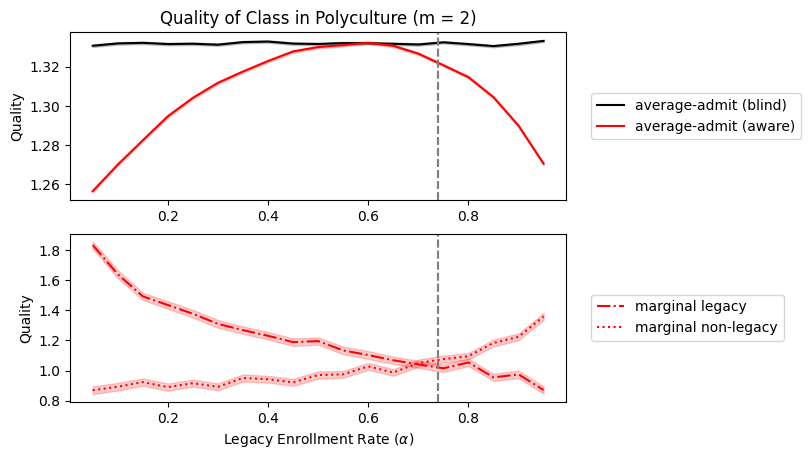

In [25]:
plot_legacy_experiment_result(num_schools=2, T=400, xline=[0.74, 0.74])

## Four Schools

### Generating Data

This cell generates data, and the second cell plots the data. This cell can be skipped and the next cell will plot pre-generated data (note that the data generation may take a significant amount of time). 

In [13]:
run_legacy_experiment(num_schools=4, T=400)


### Plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


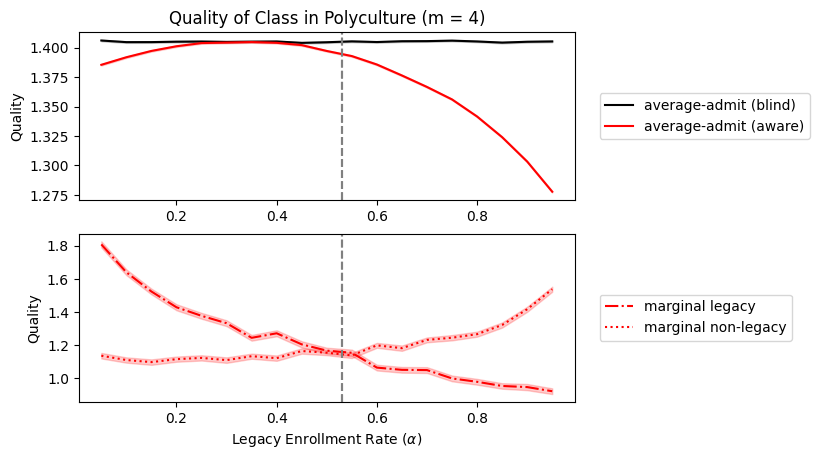

In [26]:
plot_legacy_experiment_result(num_schools=4, T=400, xline=[0.53, 0.53])

## Eight Schools

### Generating Data

This cell generates data, and the second cell plots the data. This cell can be skipped and the next cell will plot pre-generated data (note that the data generation may take a significant amount of time). 

In [15]:
run_legacy_experiment(num_schools=8, T=400)


### Plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


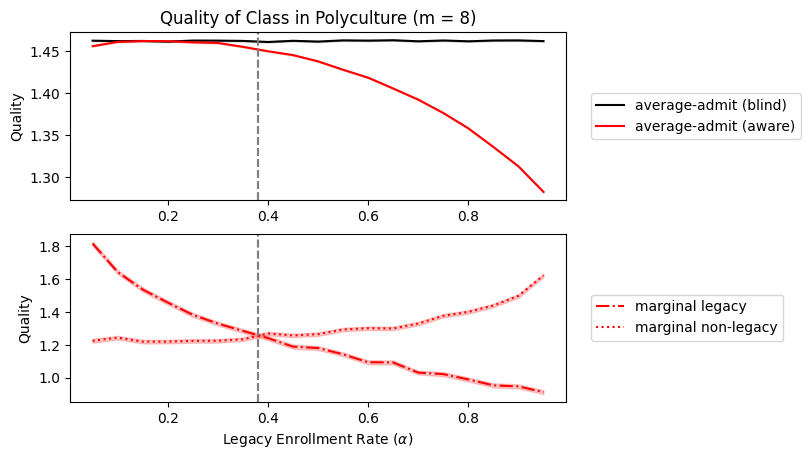

In [27]:
plot_legacy_experiment_result(num_schools=8, T=400, xline=[0.38, 0.38])

## 16 Schools

### Generating Data

This cell generates data, and the second cell plots the data. This cell can be skipped and the next cell will plot pre-generated data (note that the data generation may take a significant amount of time). 

In [17]:
run_legacy_experiment(num_schools=16, T= 400)

### Plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


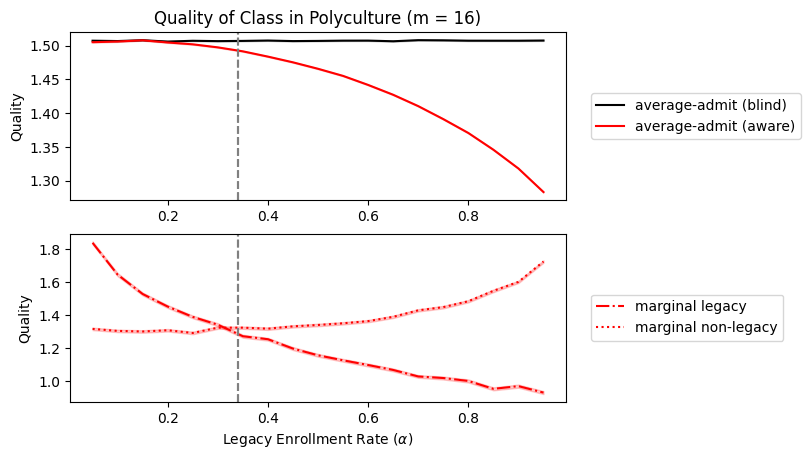

In [28]:
plot_legacy_experiment_result(num_schools=16, T = 400, xline=[0.34, 0.34])